In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
sns.set()

import torch 
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable # storing data while learning
from torch import optim
from torch.utils import data as utilsdata
import torch.nn.functional as F
from torch.distributions import Categorical
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from scipy.signal import argrelmax

## Create a simple dataset

('X.shape =', (6000, 1))
('X_train.shape =', (4500, 1), 'X_test.shape =', (1500, 1))


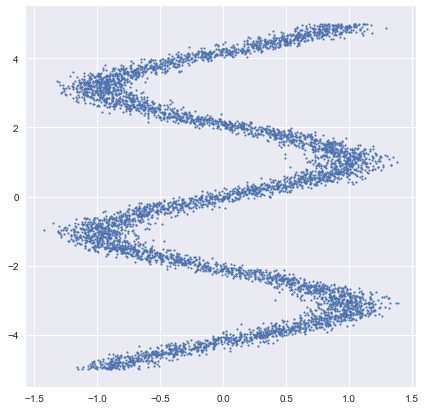

In [3]:
n_samples = 6000
y = np.random.uniform(-5, 5, size=n_samples)
x = np.sin(1.5*y) + np.random.normal(scale=0.15, size=n_samples)
X = x.reshape((-1, 1))
Y = y.reshape((-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)
# create data loaders
batch_size = 50
train = utilsdata.TensorDataset(torch.from_numpy(X_train.astype('float32')),
                                torch.from_numpy(y_train.astype('float32')))
test = utilsdata.TensorDataset(torch.from_numpy(X_test.astype('float32')),
                               torch.from_numpy(y_test.astype('float32')))
train_loader = torch.utils.data.DataLoader(
                 dataset=train,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test,
                batch_size=batch_size,
                shuffle=False)

print('X.shape =', X.shape)
print('X_train.shape =', X_train.shape, 'X_test.shape =', X_test.shape)
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(x, y, s=3)

## Create a multi-dimensional dataset

('X.shape =', (6000, 2))
('X_train.shape =', (4500, 2), 'X_test.shape =', (1500, 2))


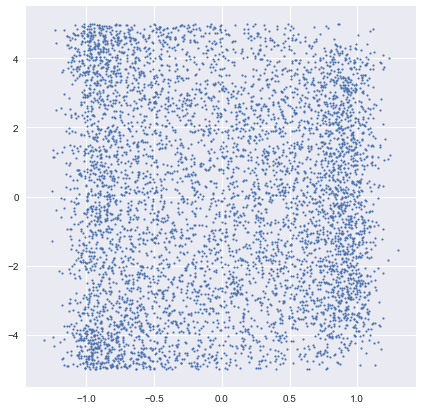

In [4]:
n_samples = 6000
n_input = 2
n_output = 3
Y = np.random.uniform(-5, 5, size=(n_samples, n_output))
z = np.sqrt(np.sum(np.square(Y), axis=1))
X = np.column_stack([np.sin(1.5*z), np.cos(1.5*z)])
X += np.random.normal(scale=0.1, size=(n_samples, n_input))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)
# create data loaders
batch_size = 50
train = utilsdata.TensorDataset(torch.from_numpy(X_train.astype('float32')),
                                torch.from_numpy(y_train.astype('float32')))
test = utilsdata.TensorDataset(torch.from_numpy(X_test.astype('float32')),
                               torch.from_numpy(y_test.astype('float32')))
train_loader = torch.utils.data.DataLoader(
                 dataset=train,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test,
                batch_size=batch_size,
                shuffle=False)

print('X.shape =', X.shape)
print('X_train.shape =', X_train.shape, 'X_test.shape =', X_test.shape)
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(X[:, 1], Y[:, 0], s=3)

## Define and run the mixture density network

In [5]:
class MixtureDensityNetwork(nn.Module):
    '''Create a mixture density network
    Args:
        n_input: number of input dimensions
        n_hiddens: an integer or a list. Sizes of hidden layers.
        n_output: number of output dimensions
        n_components: number of Gaussian distributions
        logsigma_min, logsigma_max: range to clip log sigma to
    '''
    def __init__(self, n_input = 24, n_hiddens = 10, n_output = 6, 
                 n_components=4, 
                 logsigma_min=-3, logsigma_max=3):
        super(MixtureDensityNetwork, self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.n_components = n_components
        self.n_hiddens = np.atleast_1d(n_hiddens)
        self.logsigma_min = logsigma_min
        self.logsigma_max = logsigma_max
        
        layers = []
        n_hidden_prev = n_input
        for n in self.n_hiddens:
            layers.append(nn.Linear(n_hidden_prev, n))
            layers.append(nn.ReLU())
            n_hidden_prev = n
        layers.append(nn.Linear(n_hidden_prev, n_components*(2*n_output + 1)))
        self.encoder = nn.Sequential(*layers)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.encoder(x)
        logsigma = torch.clamp(0.5*x[:, :self.n_components*self.n_output], 
                            self.logsigma_min, 
                            self.logsigma_max)
        logsigma = logsigma.view(-1, self.n_components, self.n_output)
        mu = x[:, (self.n_components*self.n_output):(self.n_components*self.n_output*2)]
        mu = mu.view(-1, self.n_components, self.n_output)
        logpi = torch.log(self.softmax(x[:, (self.n_components*self.n_output*2):]))
        logpi = logpi.view(-1, self.n_components)
        
        return logpi, logsigma, mu

def mdn_logp(x, logpi, logsigma, mu):
    '''Loss function of a mixture density network is the negative log likelihood of a Gaussian mixture
    Args:
        x: Tensor of shape [batch_size, n_dim]
        logpi: Tensor of shape [batch_size, n_components]
        logsigma: Tensor of shape [batch_size, n_components, n_dim]
        mu: Tensor of shape [batch_size, n_components, n_dim]
    Returns:
        Log likelihoods of input samples. Tensor of shape [batch_size]
    '''
    batch_size, n_components, n_dim = logsigma.size()
    x = x.view(batch_size, -1, n_dim)
    logpi = logpi.view(batch_size, n_components, -1)
    var = torch.pow(torch.exp(logsigma), 2)
    #print(x.size(), logpi.size(), logsigma.size(), mu.size())
    ll_gaussian = -float(0.5*np.log(2*np.pi)) - logsigma - 0.5/var*torch.pow(x - mu, 2)
    ll = torch.logsumexp(ll_gaussian + logpi, 1)
    return ll

def mdn_loss(x, logpi, logsigma, mu):
    '''Same as mdn_logp except that the log likelihoods are negated and averaged across samples
    Returns:
        Negative log likelihood of input samples averaged over samples. A scalar.
    '''
    return torch.mean(-mdn_logp(x, logpi, logsigma, mu))

model = MixtureDensityNetwork(n_input=2, n_output=3, n_components=6, n_hiddens=[10, 10, 10])
optimizer = optim.Adam(model.parameters())

for epoch in range(100):
    train_loss = []
    for i_batch, batch_data in enumerate(train_loader):
        x, y = batch_data
        model.zero_grad()
        logpi, logsigma, mu = model(x) 
        loss = mdn_loss(y, logpi, logsigma, mu)
        loss.backward()
        optimizer.step() 
        train_loss.append(loss.item()*x.size()[0])
    train_loss = np.sum(train_loss)/len(train_loader.dataset)
    test_loss = []
    with torch.no_grad():
        for i_batch, batch_data in enumerate(test_loader):
            x, y = batch_data
            logpi, logsigma, mu = model(x) 
            loss = mdn_loss(y, logpi, logsigma, mu)
            test_loss.append(loss.item()*x.size()[0])
        test_loss = np.sum(test_loss)/len(test_loader.dataset)
    if epoch%10 == 0:
        print('[Epoch {:d}] train loss: {}, test loss: {}'.format(epoch, train_loss, test_loss))

AttributeError: 'module' object has no attribute 'logsumexp'

In [6]:
logsigma.shape

torch.Size([50, 6, 3])

## Plot the learned probability densities

(-5, 5)

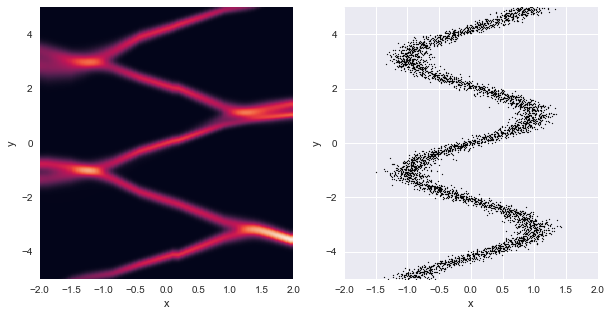

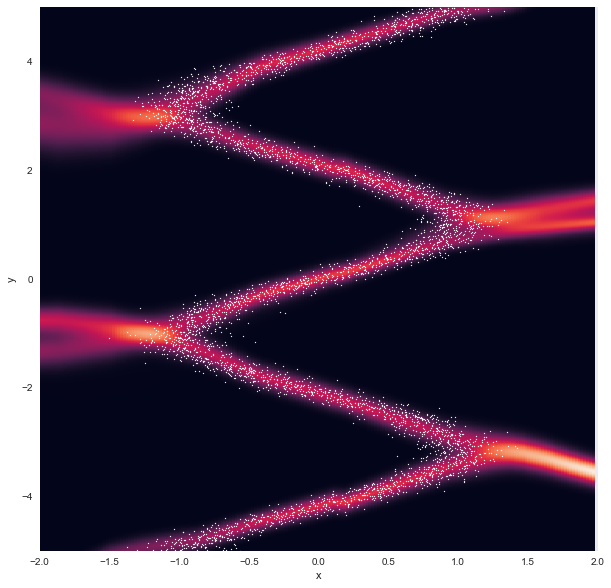

In [152]:
# predict mixture densities
with torch.no_grad():
    X_grid, Y_grid = np.mgrid[-2:2:0.02, -5:5:0.01]
    X_grid = X_grid.T.astype('float32')
    Y_grid = Y_grid.T.astype('float32')
    logpi, logsigma, mu = model(torch.from_numpy(X_grid.reshape(-1, 1)))
    ll = mdn_logp(torch.from_numpy(Y_grid.reshape((-1, 1))), logpi, logsigma, mu)
    p = np.exp(ll.numpy()).reshape(X_grid.shape)
    
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].pcolormesh(X_grid, Y_grid, p)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_xlim(-2, 2)
axes[0].set_ylim(-5, 5)

axes[1].scatter(X_train[:, 0], y_train[:, 0], s=1, c='k')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_xlim(-2, 2)
axes[1].set_ylim(-5, 5)

fig, ax = plt.subplots(figsize=(10, 10))
ax.pcolormesh(X_grid, Y_grid, p)
ax.scatter(X_train[:, 0], y_train[:, 0], s=1, c='white')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-2, 2)
ax.set_ylim(-5, 5)

## Plot the mixture centers

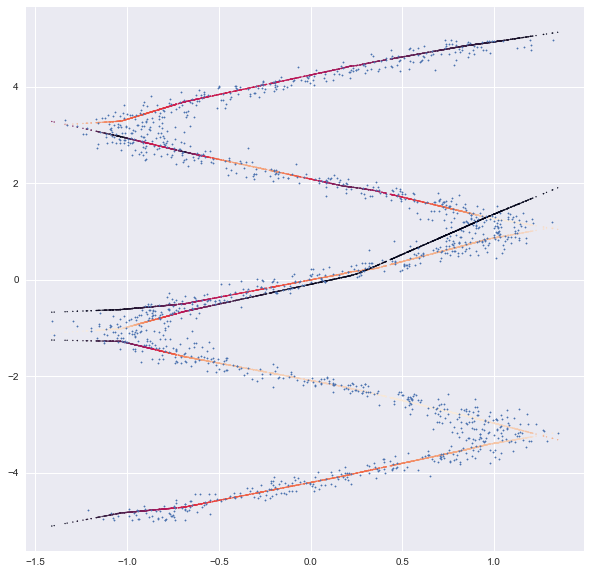

In [120]:
with torch.no_grad():
    logpi, logsigma, mu = model(torch.from_numpy(X_test.astype('float32')))
    pi = np.exp(logpi.data)
    mu = mu.data
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(pi.shape[1]):
    ax.scatter(X_test[:, 0], mu[:, i], c=pi[:, i], s=1)
ax.scatter(X_test[:, 0], y_test[:, 0], s=2)

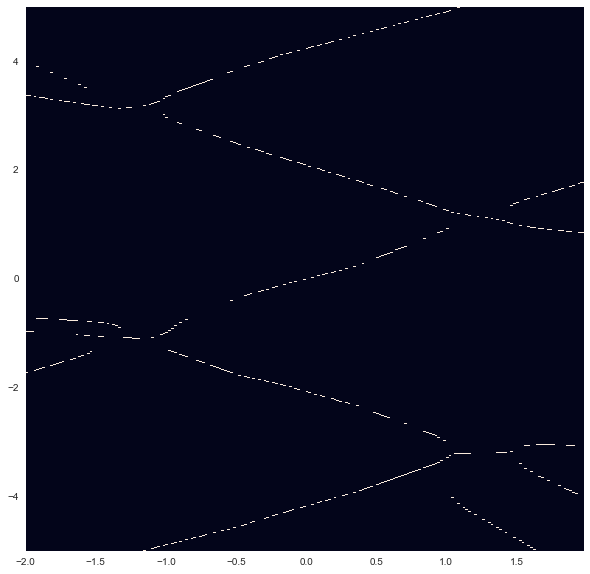

In [143]:
ii, jj = argrelmax(p, axis=0, order=2)
peaks = np.zeros(p.shape, dtype=np.int32)
peaks[ii, jj] = 1
fig, ax = plt.subplots(figsize=(10, 10))
ax.pcolormesh(X_grid, Y_grid, peaks)